In [1]:
import h5py
import os
import glob
import shutil
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from xray_binary_utils import stellar, compas_utils

from typing import Tuple

In [156]:
compas_utils.run_compas(5000)

## Accretion disk luminosity

In [19]:
def accretion_luminosity(mass, dmass, radius):
    return 1.90809*1e5*mass*dmass/radius

In [67]:
def calculate_compact_object_values(n_systems: int = 100):
    # ages, luminosities
    
    xray_luminosities = []
    accretor_ages = []
    accretion_durations = []
    
    def is_accreting_onto_co(datum: np.array, donor_ind: int, acceptor_ind: int, ind: int) -> bool:
        return stellar.is_compact_object(datum[f'Stellar_Type({acceptor_ind})'][ind]) and \
            stellar.is_main_sequence(datum[f'Stellar_Type({donor_ind})'][ind]) and datum[f'dmMT({acceptor_ind})'][ind] > 0.0
    
    for n in range(n_systems):
    
        output = compas_utils.open_detailed_output(n)
        
        accretion_indices = np.flatnonzero(output[f'dmMT(1)'])
        
        if len(accretion_indices) > 0:
            
            # Check if the accretion is occuring onto a compact object
            accretion_onto_co_indices = []
            acceptor_ind = None
            
            for ind in accretion_indices:
                
                # 1 is accreting onto 2
                if is_accreting_onto_co(output, 1, 2, ind):
                    accretion_onto_co_indices.append(ind)
                    acceptor_ind = 2
                # 2 is accreting onto 1
                elif is_accreting_onto_co(output, 2, 1, ind):
                    accretion_onto_co_indices.append(ind)
                    acceptor_ind = 1
                
            if len(accretion_onto_co_indices) > 0:
                
                xray_luminosities.append(accretion_luminosity(mass = output[f'Mass({acceptor_ind})'][accretion_onto_co_indices],
                                                              dmass = output[f'dmMT({acceptor_ind})'][accretion_onto_co_indices] * output[f'dT'][accretion_onto_co_indices] / 1e6,
                                                              radius = output[f'Radius({acceptor_ind})'][accretion_onto_co_indices]))
                accretor_ages.append(output[f'Age({acceptor_ind})'][accretion_onto_co_indices])
                accretion_durations.append(output[f'dT'][accretion_onto_co_indices])
    
    return np.array([accretor_ages, accretion_durations, xray_luminosities]).T

In [72]:
ns = calculate_compact_object_values(1000)

<ipython-input-67-b9b14c343272>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([accretor_ages, accretion_durations, xray_luminosities]).T


In [81]:
from collections import defaultdict

In [223]:
def flattened_xray_luminosities(n_systems: int = 100):
    # ages, luminosities
    
    xray_luminosities = defaultdict(list)
    
    def is_accreting_onto_co(datum: np.array, donor_ind: int, acceptor_ind: int, ind: int) -> bool:
        return stellar.is_compact_object(datum[f'Stellar_Type({acceptor_ind})'][ind]) and \
            stellar.is_main_sequence(datum[f'Stellar_Type({donor_ind})'][ind]) and datum[f'dmMT({acceptor_ind})'][ind] > 0.0
    
    for n in range(n_systems):
    
        output = compas_utils.open_detailed_output(n)
        
        accretion_indices = np.flatnonzero(output[f'dmMT(1)'])
        
        if len(accretion_indices) > 0:
            
            # Check if the accretion is occuring onto a compact object
            accretion_onto_co_indices = []
            acceptor_ind = None
            donor_ind = None
            
            for ind in accretion_indices:
                
                # 1 is accreting onto 2
                if is_accreting_onto_co(output, 1, 2, ind):
                    accretion_onto_co_indices.append(ind)
                    donor_ind = 1
                    acceptor_ind = 2
                # 2 is accreting onto 1
                elif is_accreting_onto_co(output, 2, 1, ind):
                    accretion_onto_co_indices.append(ind)
                    acceptor_ind = 1
                    donor_ind = 2
                
            for ind in accretion_onto_co_indices:
                
                luminosity = accretion_luminosity(mass = output[f'Mass({acceptor_ind})'][ind],
                                                  dmass = output[f'dmMT({acceptor_ind})'][ind] * output[f'dT'][ind] / 1e6,
                                                  radius = output[f'Radius({acceptor_ind})'][ind])
                
                if luminosity > 400:
                    # print('Mass:', output[f'Mass({acceptor_ind})'][ind], 'dM/T:', output[f'dmMT({acceptor_ind})'][ind], 'dT:', output[f'dT'][ind],
                    #       'radius:', output[f'Radius({acceptor_ind})'][ind])
                    continue
                
                xray_luminosities[np.around(output[f'Age({acceptor_ind})'][ind], -1)].append(luminosity)
                
    
    return xray_luminosities

In [224]:
luminosities = flattened_xray_luminosities(5000)

In [225]:
ages = list(luminosities.keys())
ages.sort()
xray_luminosities = []

# Omit the 0th age
for age in ages[1:-30]:
    xray_luminosities.append(np.sum(luminosities[age]))

In [226]:
import matplotlib.pyplot as plt

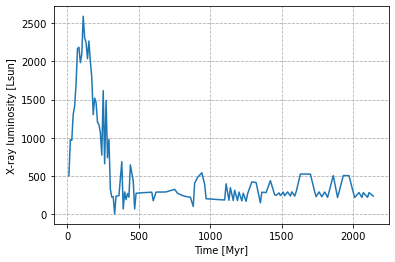

In [227]:
plt.plot(ages[1:-30], xray_luminosities)
plt.grid(linestyle = "--")
plt.gca().set_ylabel('X-ray luminosity [Lsun]');
plt.gca().set_xlabel('Time [Myr]');